In [25]:
# Start Spark and SQL
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Mini-Projects").getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [61]:
from pyspark.sql.types import *
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from matplotlib import pyplot as plt

In [50]:
# read in csvs, make sure to put in hdfs:
#hdfs dfs -put subreddit_bodies.csv  
#hdfs dfs -put subreddit_score.csv

df_score = pd.read_csv("subreddit_score.csv")
df_body = pd.read_csv("subreddit_bodies.csv")

#drop indices
subreddit = df_body.drop(df_body.columns[0], axis=1)
df_score = df_score.drop(df_score.columns[0], axis=1)

In [81]:
# subset for top 1,000 and 10 subreddits based on average score
top_1000 = df_score[:1000]
top_10 = df_score[:10]

In [82]:
#Cast indices as strings
subreddit.subreddit = subreddit.subreddit.astype(str)
top_1000.subreddit = top_1000.subreddit.astype(str)

#Left Join datasets on subreddit to only keep top 1,000 subreddits with field for body
join_data = top_1000.set_index('subreddit').join(subreddit.set_index('subreddit'))
join_data.reset_index(level=0, inplace=True)

In [83]:
# Remove rows where body was deleted or removed
join_data = join_data[join_data.body != "[deleted]"]
join_data = join_data[join_data.body != "[removed]"]

In [84]:
# convert back to spark dataframe
df_sub_maxbod = spark.createDataFrame(join_data)

In [85]:
# run k-means clustering on body for 10 clusters
df_sub_maxbod.cache().count()

# tokenize, remove stopwords, and vectorize text
tokenizer = Tokenizer(inputCol= "body", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens")
hashingTF = HashingTF(inputCol="stopWordsRemovedTokens", outputCol="rawFeatures", 
                      numFeatures=3)
idf = IDF(inputCol="rawFeatures", outputCol="features")
kmeans = KMeans(k=10)

# pipeline and fit model
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, kmeans])
model = pipeline.fit(df_sub_maxbod)

#store results
results = model.transform(df_sub_maxbod)
results.cache()

DataFrame[subreddit: string, avg_score: double, body: string, tokens: array<string>, stopWordsRemovedTokens: array<string>, rawFeatures: vector, features: vector, prediction: int]

In [86]:
# Number of subreddits in each cluster
results.groupBy("prediction").count().orderBy("prediction", ascending= True).show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  252|
|         1|   17|
|         2|    1|
|         3|  473|
|         4|   29|
|         5|    1|
|         6|    3|
|         7|    9|
|         8|   99|
|         9|   48|
+----------+-----+



In [87]:
# Find cluster centers
model_stage = model.stages[-1]
centers = model_stage.clusterCenters()

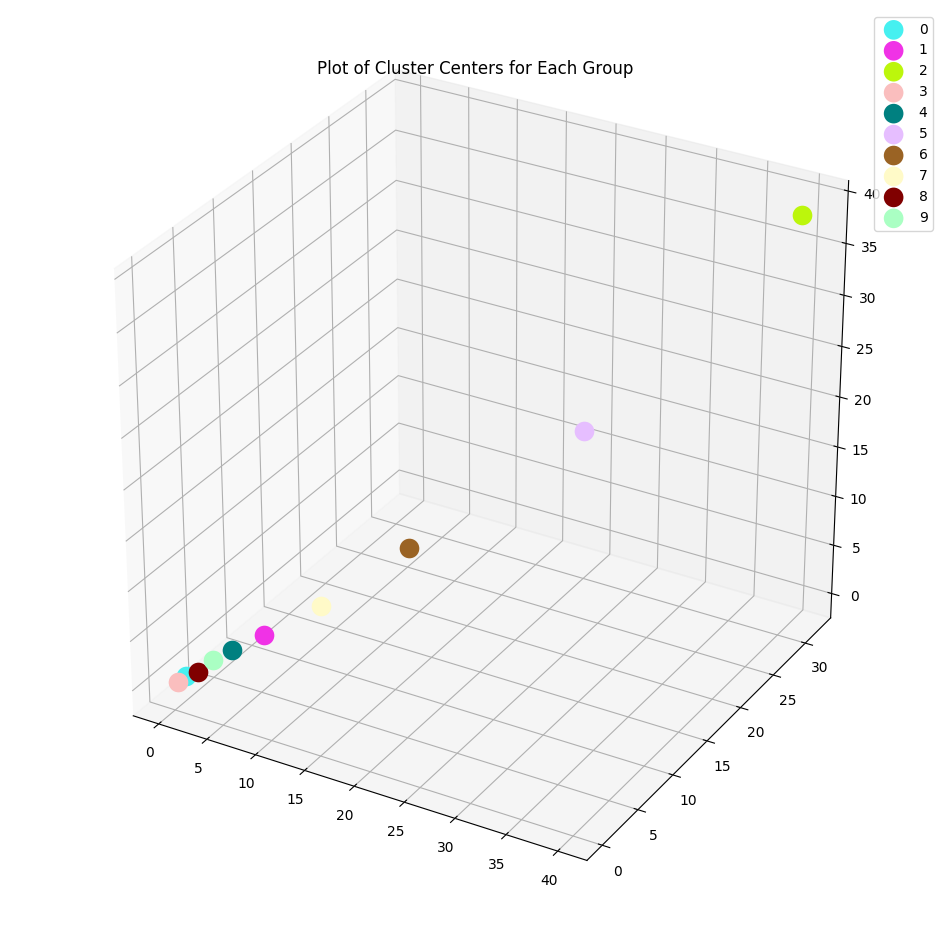

In [88]:
# Set up cluster centers and prediction labels to plot 
columns = ["x", "y", "z"]
pred = range(0,10)  
data = centers
for_plot = pd.DataFrame(data=data, columns= columns)
for_plot.loc[:,'pred'] = pd.Series(pred, index=for_plot.index)

#Make color palette
colors = ( '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
          '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1')
c_list = []
for c in colors:
    c_list.append([c]*1)

#Create plot
fig = plt.figure(figsize=(12, 12), dpi=100)
ax = fig.gca(projection='3d')
ax.set_title('Plot of Cluster Centers for Each Group')

for x,y,z, color, group in zip(for_plot['x'],for_plot['y'],for_plot['z'], c_list, for_plot['pred']):
    ax.scatter(x,y,z, c= color, edgecolors='none', s=200, label= group, )
    ax.legend()

plt.show()

In [89]:
# Label 2 cluster Subreddit
pred_5 = results.filter(results.prediction.isin([2]))
pred_5.select("prediction", "Subreddit").show()

+----------+--------------+
|prediction|     Subreddit|
+----------+--------------+
|         2|LetterstoJNMIL|
+----------+--------------+



In [90]:
# average score of this subreddit
sub_df = top_1000.loc[top_1000["subreddit"] == "LetterstoJNMIL"]
print("Average Score:", sub_df.iloc[0]['avg_score'])

Average Score: 14.31567549558554


In [92]:
# Label 2 cluster Subreddit
pred_5 = results.filter(results.prediction.isin([5]))
pred_5.select("prediction", "Subreddit").show()

+----------+-------------------+
|prediction|          Subreddit|
+----------+-------------------+
|         5|restofthefuckingowl|
+----------+-------------------+



In [93]:
# average score of this subreddit
sub_df = top_1000.loc[top_1000["subreddit"] == "restofthefuckingowl"]
print("Average Score:", sub_df.iloc[0]['avg_score'])

Average Score: 19.25678610206297


In [91]:
# Top 10 highest scoring subreddits' clusters
pred_top_10 = results.filter(results.subreddit.isin(list(top_10["subreddit"])))
pred_top_10.select("prediction", "subreddit").show()

+----------+--------------------+
|prediction|           subreddit|
+----------+--------------------+
|         3|               awwaf|
|         0|           u_dav2306|
|         3|             u_z_cat|
|         3|   u_jordancambridge|
|         3|  HorimotoCircleJerk|
|         3| u_Intuit_QuickBooks|
|         3|CountryGirlsGoneWild|
|         0|     menwritingwomen|
|         3|   ComedyArchaeology|
+----------+--------------------+



In [94]:
sc.stop()